In [25]:
import pandas as pd
from datetime import datetime #para crear fechas manualmente
import matplotlib.pyplot as plt

Importamos los datos

In [26]:
ruta = r'/content/drive/MyDrive/Colab Notebooks/Series temporales/datasets/series_mensuales.xlsx'
columnas = ['Unnamed: 0','ipc' ,'ipener']
mensuales = pd.read_excel(ruta, sheet_name='Datos').loc[:, columnas]
mensuales.rename(columns= {'Unnamed: 0': 'fecha'}, inplace=True) 

ruta = r'/content/drive/MyDrive/Colab Notebooks/Series temporales/datasets/series_trimestrales.xlsx'
columnas = ['Unnamed: 0','pib', 'tnp', 'tno']
trimestrales = pd.read_excel(ruta, sheet_name='VARIABLES').loc[:, columnas]
trimestrales.rename(columns= {'Unnamed: 0': 'fecha'}, inplace=True) 

In [27]:
print('Series mensuales:\n')
print(mensuales.head())
print('\nSeries trimestrales:\n')
print(trimestrales.head())

Series mensuales:

     fecha  ipc  ipener
0  1975-01  NaN     NaN
1  1975-02  NaN     NaN
2  1975-03  NaN     NaN
3  1975-04  NaN     NaN
4  1975-05  NaN     NaN

Series trimestrales:

     fecha      pib  tnp      tno
0  1995(1)  63.4509  NaN  13821.6
1  1995(2)  67.2675  NaN  13845.3
2  1995(3)  65.2285  NaN  13838.8
3  1995(4)  69.8822  NaN  13859.0
4  1996(1)  64.9299  NaN  13894.9


Adaptamos la fecha de mensuales a formato de fecha y lo fijamos como indice del dataframe

In [28]:
mensuales['fecha'] = pd.to_datetime(mensuales['fecha'])
mensuales.set_index('fecha', inplace=True)
mensuales.tail()

,ipc,ipener
fecha,,
2020-10-01,104.275,NaN
2020-11-01,NaN,NaN
2020-12-01,NaN,NaN
2021-01-01,NaN,NaN
2021-02-01,NaN,NaN


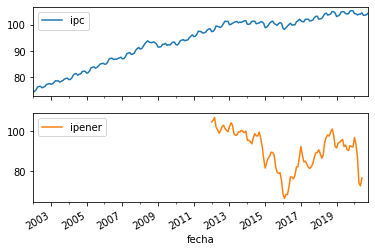

In [16]:
mensuales.dropna(how='all', inplace=True)
mensuales.plot(subplots=True);

             pib     tnp      tno
fecha                            
2020Q2   88.0712  3368.0  18729.6
2020Q3  100.7402  3722.9  19356.8
2020Q4       NaN  3719.8  19627.0 



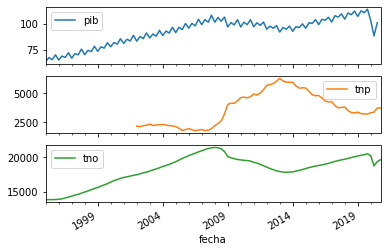

In [29]:
# Convertirmos la columna fecha según ejemplo: tercer trimestre 1995 = 1995Q3 
trimestrales['fecha'] = trimestrales.fecha.str.replace('(', 'Q')
trimestrales['fecha'] = trimestrales.fecha.str.rstrip(')')

# podemos tratar la columna fecha como una fecha
# trimestrales['fecha'] = pd.to_datetime(trimestrales.fecha)

# o como un periodo (trimestral = Quarterly)
trimestrales['fecha'] = pd.PeriodIndex(trimestrales.fecha, freq='Q')
trimestrales.set_index('fecha', inplace=True)
trimestrales.dropna(how='all', inplace=True)

#Visualizamos la transformación
print(trimestrales.tail(3), '\n')
trimestrales.plot(subplots=True);


Podemos comparar la evolución mensual del IPC en tres años diferentes



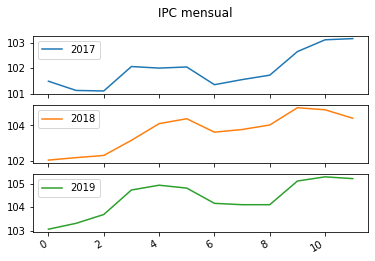

In [19]:
# Creamos un dataframe vacío
producto = pd.DataFrame()

# Seleccionamos los valores de cada año y los concatenamos con el df 
for year in ['2017', '2018', '2019']:
  # creamos una columna para cada valor de la iteración y quimos el índice
  prod_anual = mensuales.loc[year, ['ipc']].reset_index(drop=True)
  # renombramos la columna según el valor del iterable
  prod_anual.rename(columns={'ipc': year}, inplace=True)
  # asignamos la columna al df
  producto = pd.concat([producto, prod_anual], axis=1)

# Plot prices
producto.plot(subplots=True, title='IPC mensual');

Alternativamente podríamos ver las variaciones porcentuales de cada valor respecto al mes anterior y al año anterior

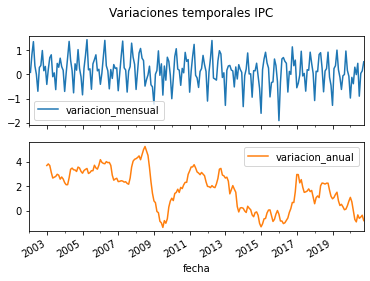

In [20]:
# Create monthly_return
mensuales['variacion_mensual'] = mensuales.ipc.pct_change().mul(100)

# Create annual_return
mensuales['variacion_anual'] = mensuales.ipc.pct_change(12).mul(100)

# Plot the result
mensuales.loc[:, ['variacion_mensual', 'variacion_anual']].plot(subplots=True,
                                                                title='Variaciones temporales IPC');

Podemos comparar las evoluciones de diferentes series temporales normalizando sus valores, es decir, dividiendo cada valor de una serie por el primer dato de esa serie y multiplicándolo por 100.

Para esta comparación es necesario que todas las series comiencen en la misma fecha.  

Comparemos los datos trimestrales de PIB, Total Nacional de Parados y Total Nacional de Ocupados

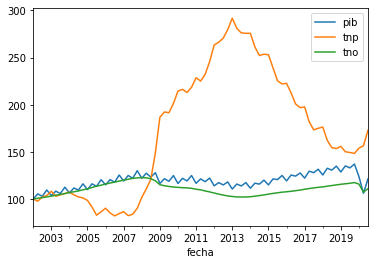

In [21]:
# eliminamos NA para que la primera fila contenga un valor valido para las 3 variables
datos = trimestrales.dropna(how='any')
# determinamos los valores iniciales de referencia
valor_inicial = datos.iloc[0]
# normalizamos los valores
normales = datos.div(valor_inicial).mul(100)
normales.plot(subplots=False)


Podríamos utilizar un valor como BENCHMARK, es decir como referencia de comparación. Por ejemplo el IPC, que  son datos mensuales con un índice de tipo fecha ```Datetime``` mientras que el PIB, el TNP y el TNO son datos trimestrales para los que hemos utilizado un índice periodo de tipo ```Period``` 


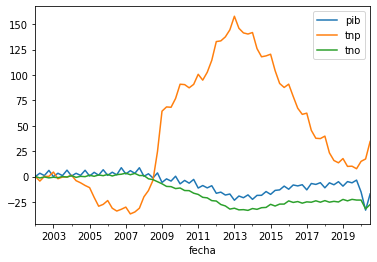

In [22]:
# Create tickers
tickers = ['MSFT', 'AAPL']
# remuestrear los datos mensuales a trimestrales sacando las medias
_ =mensuales.loc['2002': ,['ipc']].resample('Q-DEC').mean().reset_index()
# convertir columna fecha a formato Period
_.fecha = pd.PeriodIndex(_.fecha, freq='Q')
# transformar columna fecha en indice de dataframe
benchmark = _.set_index('fecha')

# Unimos los datos trimestrales con el benchmark
datos = pd.concat([benchmark, trimestrales], axis=1).dropna()

# Normalizar
normales = datos.div(datos.iloc[0]).mul(100)

# Subtract the normalized index from the normalized stock prices, and plot the result
# .sub(axis=0) alinea las filas según las fechas
normales[['pib', 'tnp', 'tno']].sub(normales['ipc'], axis=0).plot();
